In [4]:
import os
import cv2
import numpy as np
import dlib
import pandas as pd
from skimage import transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv3D, BatchNormalization, Activation, Dropout, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [5]:
# GPU configuration
import warnings
warnings.filterwarnings("ignore")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("GPU is available")
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1
GPU is available


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# Path to dlib's pre-trained face detector model
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/gdrive/My Drive/Colab Notebooks/shape_predictor_68_face_landmarks.dat')

In [8]:
def compute_shape_context(points, nbins_r=5, nbins_theta=12, r_inner=0.125, r_outer=2.0):
    """
    Compute the shape context descriptor for a set of points.

    Parameters:
    points (np.ndarray): Array of (x, y) coordinates.
    nbins_r (int): Number of bins for the radial distance.
    nbins_theta (int): Number of bins for the angular distance.
    r_inner (float): Inner radius (as a fraction of the mean distance).
    r_outer (float): Outer radius (as a multiple of the mean distance).

    Returns:
    np.ndarray: Shape context descriptor.
    """
    nsamp = points.shape[0]
    mean_dist = np.mean(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
    r_array = np.linspace(np.log(r_inner), np.log(r_outer), nbins_r)
    r_array = np.exp(r_array)
    theta_array = np.linspace(0, 2*np.pi, nbins_theta + 1)

    descriptor = np.zeros((nsamp, nbins_r * nbins_theta))

    for i in range(nsamp):
        diff = points - points[i, :]
        r = np.sqrt(np.sum(diff**2, axis=1))
        theta = np.arctan2(diff[:, 1], diff[:, 0])
        theta = theta % (2 * np.pi)

        r_bin = np.digitize(r / mean_dist, r_array)
        theta_bin = np.digitize(theta, theta_array)

        hist, _, _ = np.histogram2d(r_bin, theta_bin, bins=[nbins_r, nbins_theta])
        descriptor[i, :] = hist.flatten()

    return descriptor

In [9]:
def extract_lip_movement_features(video_path):
    """
    Extract lip movement features from a video file using Shape Context.

    Parameters:
    video_path (str): Path to the video file.

    Returns:
    np.ndarray: Extracted lip movement features.
    """
    cap = cv2.VideoCapture(video_path)
    lip_features = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        for face in faces:
            landmarks = predictor(gray, face)
            lips_points = []
            for i in range(48, 68):  # Points corresponding to the lips
                x = landmarks.part(i).x
                y = landmarks.part(i).y
                lips_points.append((x, y))
            lips_points = np.array(lips_points)
            # Compute Shape Context for lip points
            descriptor = compute_shape_context(lips_points)
            lip_features.append(descriptor.flatten())

    cap.release()
    # Convert the list of lip features to a numpy array
    return lip_features

In [10]:
def pad_features(features, max_length):
    """
    Pad feature vectors to ensure they are of the same length.

    Parameters:
    features (list of np.ndarray): List of feature vectors.
    max_length (int): Length to pad/truncate each feature vector to.

    Returns:
    np.ndarray: Padded feature vectors.
    """
    padded_features = []
    for feature in features:
        if len(feature) > max_length:
            padded_feature = feature[:max_length]
        else:
            padded_feature = np.pad(feature, (0, max_length - len(feature)), 'constant')
        padded_features.append(padded_feature)
    return np.array(padded_features)

In [11]:
# Directory containing the video data
data_dir = "/content/gdrive/My Drive/Colab Notebooks/dataset"
features_file = '/content/gdrive/My Drive/Colab Notebooks/unimodal_results/lips_features.csv'

In [12]:
if not os.path.exists(features_file):
    lip_features = []
    labels = []

    classes = os.listdir(data_dir)
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print(class_dir)
        if not os.path.isdir(class_dir):
            continue
        for video_file in os.listdir(class_dir):
            video_path = os.path.join(class_dir, video_file)
            features = extract_lip_movement_features(video_path)
            lip_features.extend(features)
            labels.extend([class_name] * len(features))

    # Find the maximum feature length
    max_length = max(len(f) for f in lip_features)
    # Pad features to the same length
    lip_features = pad_features(lip_features, max_length)
    # Save features to a CSV file
    df = pd.DataFrame(lip_features)
    df['label'] = labels
    df.to_csv(features_file, index=False)
else:
    # Load features from the CSV file
    df = pd.read_csv(features_file)
    lip_features = df.iloc[:, :-1].values
    labels = df['label'].values

In [16]:
!pip install pycaret

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pycaret.classification import setup, compare_models, pull, save_model

# Load dataset
csv_file = '/content/gdrive/My Drive/Colab Notebooks/unimodal_results/lips_features.csv'
df = pd.read_csv(csv_file)

# Separate features and labels
X = df.iloc[:, :-1].values  # All columns except the last one are features
y = df['label'].values      # The last column is the label

# Set up PyCaret
data = pd.DataFrame(X)
data['label'] = y

# Ensure all feature columns are of type float
data.iloc[:, :-1] = data.iloc[:, :-1].astype(float)

clf_setup = setup(data, target='label', session_id=123, verbose=False)

# Train the model
with tf.device('/GPU:0'):
    models_to_compare = ['lr', 'knn', 'nb', 'dt', 'svm', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'lda', 'et']
    best_model = compare_models(include=models_to_compare)

# Display model comparison results
results = pull()
print(results)

# Save the model comparison results to a CSV file
results.to_csv('/content/gdrive/My Drive/Colab Notebooks/unimodal_results/lips_model_metric.csv', index=False)

# Save the best model
save_model(best_model, 'best_model_lips')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9198,0.9976,0.9198,0.9213,0.9188,0.9175,0.9176,16.2240
lr,Logistic Regression,0.9173,0.0000,0.9173,0.9180,0.9170,0.9149,0.9150,177.8820
mlp,MLP Classifier,0.9142,0.9980,0.9142,0.9167,0.9139,0.9118,0.9119,123.5960
rf,Random Forest Classifier,0.9114,0.9971,0.9114,0.9130,0.9101,0.9089,0.9090,11.2250
svm,SVM - Linear Kernel,0.8739,0.0000,0.8739,0.8927,0.8753,0.8702,0.8708,56.3430
knn,K Neighbors Classifier,0.8454,0.9711,0.8454,0.8488,0.8428,0.8410,0.8412,7.9600
lda,Linear Discriminant Analysis,0.8324,0.0000,0.8324,0.8381,0.8320,0.8277,0.8278,6.5140
ridge,Ridge Classifier,0.8140,0.0000,0.8140,0.8248,0.8075,0.8085,0.8090,1.8590
dt,Decision Tree Classifier,0.7569,0.8751,0.7569,0.7588,0.7563,0.7500,0.7501,3.3450
nb,Naive Bayes,0.4597,0.8695,0.4597,0.5638,0.4288,0.4478,0.4520,2.6970


Processing:   0%|          | 0/53 [00:00<?, ?it/s]

                                 Model  Accuracy     AUC  Recall   Prec.  \
et              Extra Trees Classifier    0.9198  0.9976  0.9198  0.9213   
lr                 Logistic Regression    0.9173  0.0000  0.9173  0.9180   
mlp                     MLP Classifier    0.9142  0.9980  0.9142  0.9167   
rf            Random Forest Classifier    0.9114  0.9971  0.9114  0.9130   
svm                SVM - Linear Kernel    0.8739  0.0000  0.8739  0.8927   
knn             K Neighbors Classifier    0.8454  0.9711  0.8454  0.8488   
lda       Linear Discriminant Analysis    0.8324  0.0000  0.8324  0.8381   
ridge                 Ridge Classifier    0.8140  0.0000  0.8140  0.8248   
dt            Decision Tree Classifier    0.7569  0.8751  0.7569  0.7588   
nb                         Naive Bayes    0.4597  0.8695  0.4597  0.5638   
qda    Quadratic Discriminant Analysis    0.1810  0.0000  0.1810  0.4420   
ada               Ada Boost Classifier    0.1809  0.0000  0.1809  0.1238   

           

(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['0', '1', '2', '3', '4', '5', '6',
                                              '7', '8', '9', '10', '11', '12',
                                              '13', '14', '15', '16', '17', '18',
                                              '19', '20', '21', '22', '23', '24',
                                              '25', '26', '27', '28', '29',...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='sqrt',
                                       max_leaf_nodes=

In [13]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(lip_features, labels_categorical, test_size=0.2, stratify=labels)

In [15]:
# Reshape the data for the Conv3D layer
X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension
X_test = np.expand_dims(X_test, axis=-1)

In [16]:
# For Conv3D, we need a 5D tensor: (batch_size, depth, height, width, channels)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], 1, 1)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1, 1)

In [17]:
# Define a refined Temporal Convolutional Network (TCN) model
def build_tcn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv3D(64, (1, 3, 3), padding='same', kernel_regularizer=l2(0.01), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # Flatten the output to feed into Conv1D layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))

    model.add(Dense(num_classes, activation='softmax'))
    return model

In [18]:
input_shape = (1, X_train.shape[2], 1, 1)
num_classes = len(np.unique(labels))

In [19]:
np.unique(labels)

array(['Adriano', 'Albert', 'Alessandra', 'AlessandroQ', 'AlessandroS',
       'Alex', 'Andrea', 'AndreaG', 'Cantarella', 'Carlo', 'Cristian',
       'Davide', 'Edoardo', 'Emilio', 'Ernesto', 'Fabio', 'Francesca',
       'FrancescoG', 'Gabriele', 'GabrieleG', 'GiuseppeV', 'Iris',
       'Jacopo', 'Lorenzo', 'LorenzoC', 'Luca', 'Mansueto', 'MatteoM',
       'Mattia', 'MattiaC', 'Paolo', 'Rachele', 'Sabrina', 'Simone',
       'SimoneM', 'SimoneO', 'Siria', 'SiriaI', 'Solenne', 'Sophia',
       'Stefano', 'StefanoM', 'Vincenzo'], dtype=object)

In [20]:
model = build_tcn_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 1, 1200, 1, 64)      │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 1200, 1, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1, 1200, 1, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 1200, 1, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 76800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      19,661,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,673,003 (75.05 MB)

 Trainable params: 19,672,875 (75.05 MB)

 Non-trainable params: 128 (512.00 B)

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Early stopping and model checkpoint
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/unimodal_results/lips_best_model.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
#checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/unimodal_results/lips_best_model.h5', monitor='val_loss', save_best_only=True)

In [23]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.0639 - loss: 5.5505 - val_accuracy: 0.0623 - val_loss: 3.7326 - learning_rate: 0.0010
Epoch 2/100
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.0611 - loss: 3.7539 - val_accuracy: 0.0623 - val_loss: 3.6868 - learning_rate: 0.0010
Epoch 3/100
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.0630 - loss: 3.7175 - val_accuracy: 0.0623 - val_loss: 3.7193 - learning_rate: 0.0010
Epoch 4/100
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.0650 - loss: 3.6771 - val_accuracy: 0.2322 - val_loss: 2.9522 - learning_rate: 0.0010
Epoch 5/100
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.1741 - loss: 3.0667 - val_accuracy: 0.3700 - val_loss: 2.3974 - learning_rate: 0.0010
Epoch 6/100
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.2439 - loss: 2.7417 - val_accuracy: 0.4538 - val_loss: 2.1216 - learning_rate: 0.0010
Epoch 7/100
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step -

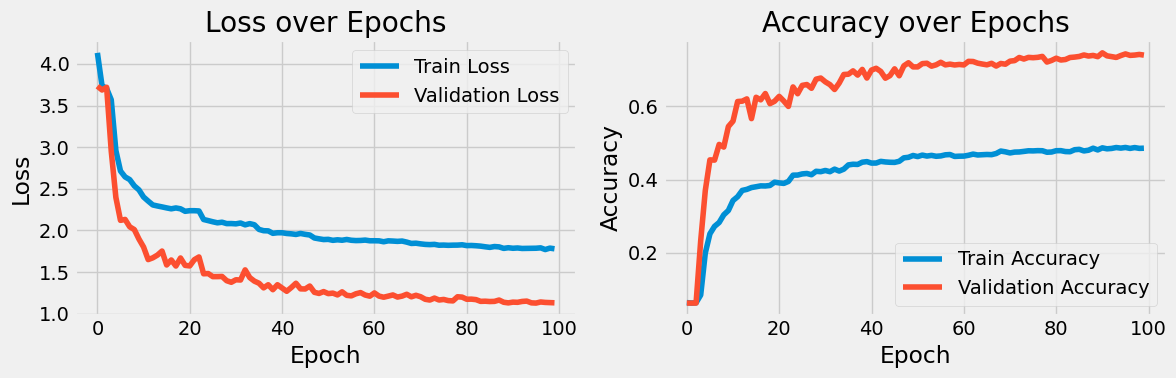

In [24]:
# Plot the loss and accuracy
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.tight_layout()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/unimodal_results/loss_accuracy_lips_shape_context.png')
plt.show()

In [25]:
# Save the model
from tensorflow.keras.models import save_model
save_model(model, '/content/gdrive/My Drive/Colab Notebooks/unimodal_results/tcn_model_lips_shape_context.h5')  # Save in format h5

In [26]:
# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.4f}%")

886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7600 - loss: 1.0810
Train Loss: 1.0810, Train Accuracy: 76.1295%


In [27]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.4f}%")

222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7452 - loss: 1.1160
Test Loss: 1.1284, Test Accuracy: 74.3470%


In [28]:
predictions = model.predict(X_test)
true_labels = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded
predicted_labels = np.argmax(predictions, axis=1)

222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


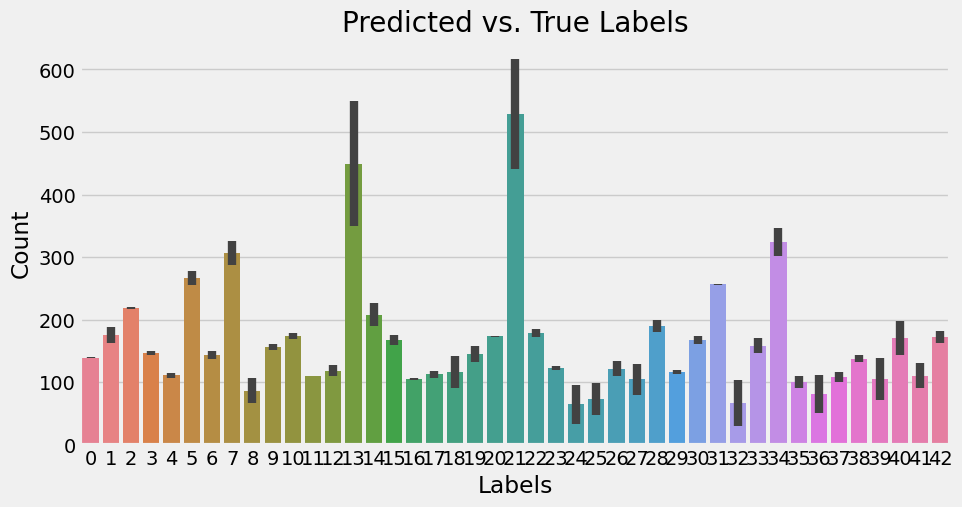

In [29]:
# Bar plot of predicted vs. true labels
plt.style.use("fivethirtyeight")
plt.figure(figsize=(10, 5))
true_labels_count = np.bincount(true_labels)
pred_labels_count = np.bincount(predicted_labels)

df = pd.DataFrame({
    'True Labels': true_labels_count,
    'Predicted Labels': pred_labels_count
}).T

sns.barplot(data=df)
plt.title('Predicted vs. True Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/speaker/inference_ssn.png')
plt.show()

In [30]:
# Create a bar plot to visualize predicted vs. true labels
#plt.style.use("fivethirtyeight")
#plt.figure(figsize=(12, 8))
#plt.plot(predicted_labels, label='Predicted', linewidth = '6.0')
#plt.plot(true_labels, label='True', linewidth = '2.0')
#plt.title('Predicted vs. True Labels')
#plt.legend()
#plt.savefig('/content/gdrive/My Drive/Colab Notebooks/unimodal_results/inference_curve_zoom_lips_shape_context.png')
#plt.show()

In [31]:
# Ensure your `classes` list matches the unique class labels
#classes = ['Adriano', 'Albert', 'Alessandra', 'Alex', 'Andrea', 'AndreaG', 'Cantarella', 'Cristian', 'Davide', 'Edoardo', 'Emilio', 'Ernesto', 'Fabio', 'Francesca', 'Iris', 'Jacopo', 'Luca', 'Mansueto', 'Mattia', 'Rachele', 'Sabrina', 'Simone', 'SimoneO', 'Siria', 'SiriaI', 'Solenne', 'Sophia', 'Stefano', 'StefanoM', 'Vincenzo']
classes = np.unique(labels)
# Ensure the number of unique labels matches the number of classes
unique_labels = np.unique(true_labels)
if len(unique_labels) != len(classes):
    print(f"Warning: Number of unique labels ({len(unique_labels)}) does not match number of classes ({len(classes)})")

In [32]:
import sklearn

# Calculate the confusion matrix
conf_matrix = sklearn.metrics.confusion_matrix(true_labels, predicted_labels)

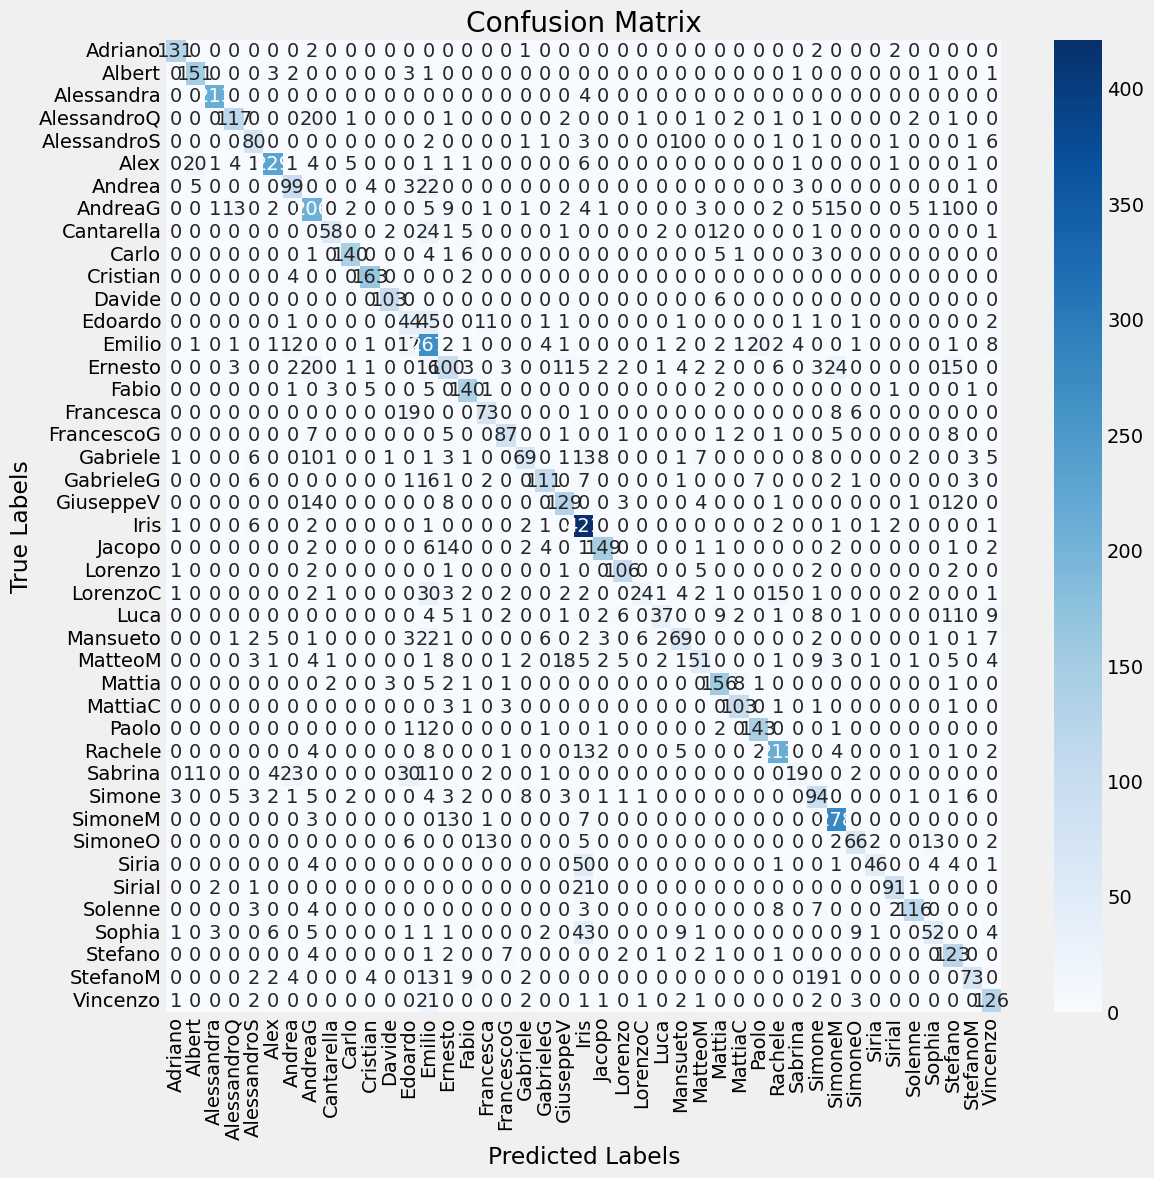

In [33]:
# Plot the confusion matrix
plt.style.use("fivethirtyeight")
y_true = true_labels
y_pred = predicted_labels
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/unimodal_results/confusion_matrix_lips_shape_context.png')
plt.show()

In [34]:
from sklearn.metrics import classification_report

# Calculate and print classification report
report = classification_report(true_labels, predicted_labels, target_names=classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Adriano       0.94      0.95      0.94       138
      Albert       0.80      0.93      0.86       163
  Alessandra       0.97      0.98      0.97       217
 AlessandroQ       0.81      0.78      0.80       150
 AlessandroS       0.70      0.75      0.72       107
        Alex       0.90      0.83      0.86       277
      Andrea       0.66      0.72      0.69       137
     AndreaG       0.63      0.72      0.67       288
  Cantarella       0.88      0.54      0.67       107
       Carlo       0.93      0.87      0.90       161
    Cristian       0.92      0.96      0.94       169
      Davide       0.94      0.94      0.94       109
     Edoardo       0.34      0.40      0.37       109
      Emilio       0.49      0.76      0.59       350
     Ernesto       0.53      0.44      0.48       226
       Fabio       0.80      0.88      0.84       159
   Francesca       0.70      0.68      0.69       107
  Fr

In [35]:
# Create a heatmap-style plot for classification report metrics
def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-5]:
        row = line.split()
        report_data.append(row)

    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(np.array(report_data)[:, 1:].astype(float), annot=True, cmap='Blues', fmt='f', xticklabels=['precision', 'recall', 'f1-score', 'support'], yticklabels=classes)
    #sns.heatmap(np.array(report_data)[:, 1:].astype(float), annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=np.array(report_data)[:, 0])
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.title("Classification Report")
    plt.savefig('/content/gdrive/My Drive/Colab Notebooks/results/classification_cropped.png')
    plt.show()

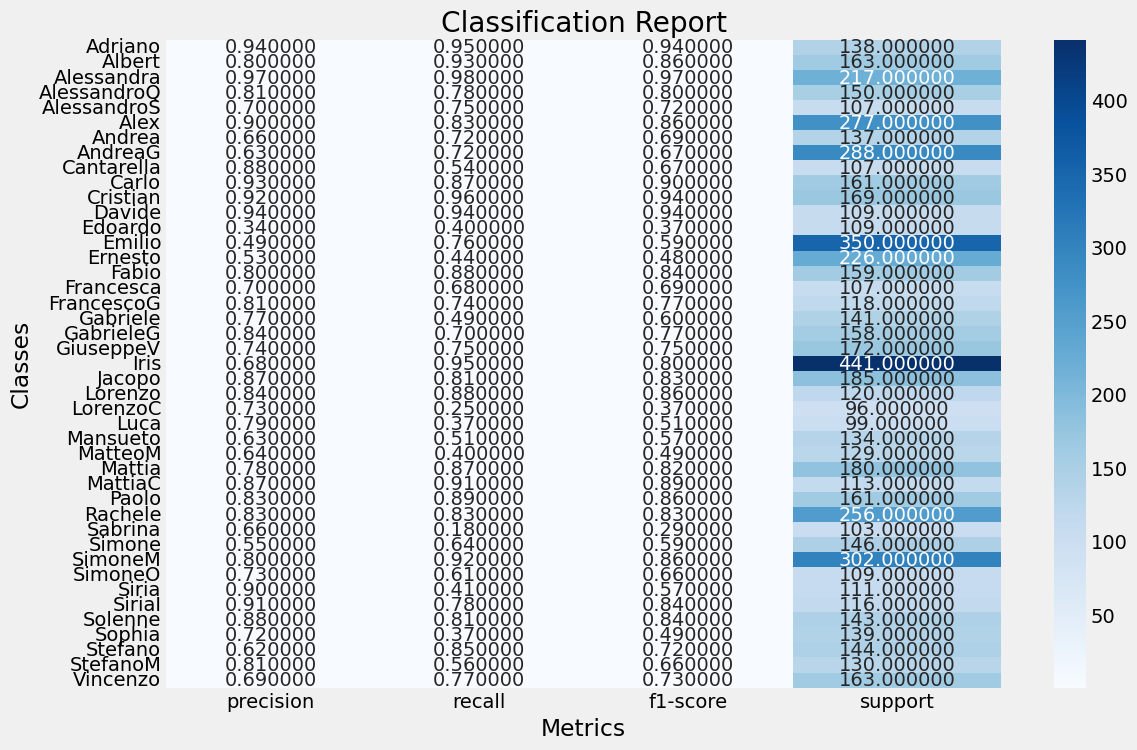

In [36]:
# Plot the classification report
plot_classification_report(report)